In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]




# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
# title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
# title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
# titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
# titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}
# titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}
# label45r = {'rotation':45, 'ha':'right'}
# label45c = {'rotation':45, 'ha':'center'}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

months = mdates.MonthLocator(bymonth=[3,6,9,12])
bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
allmonths = mdates.MonthLocator()
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False


# collect the names:
# group_names = list(these_groups.keys())

# choose a lake:
# lake = 'Lac Léman'
coi = 'Biel/Bienne'
bassin_label = 'Aare'
bassin = ['Aare', 'Aare|Nidau-Büren-Kanal','Schüss', 'Neuenburgersee', 'Thunersee','Bielersee', 'Brienzersee','La Thièle']
samples_all = 'All samples'
# lavey_locs= ['lavey-les-bains-2','lavey-les-bains', 'lavey-la-source']


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'bielsummary'
save_output = True

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# get the data
# aggregated survey data
# dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")

files_generated = []
figure_num = 1
data_num = 1

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [3]:
# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])
dfSurveys = dfSurveys[dfSurveys.date >= start_date]
dfSurveys['groupname'] = 'nogroup'

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')


In [4]:

group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}
frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}
levels={'muni':coi, 'catchment':bassin_label}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']
catchment_cols = ['region','water_name','type','city','loc_date', 'location', 'date']
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

data = dfSurveys.loc[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)].copy()
data['type'] = data.location.map(lambda x: dfBeaches[dfBeaches.index == x]['water'].values[0])    

In [5]:
dfBeaches.water_name.unique()

array(['Zurichsee', 'Aare', 'Aare|Nidau-Büren-Kanal', 'Lac Léman', 'Arve',
       'Lago Maggiore', 'Thunersee', 'Untersee', 'Bielersee', 'Birs',
       'Bodensee', 'Chriesbach', 'Neuenburgersee', 'Emme', 'Walensee',
       'Glatt', 'Goldach', 'Greifensee', 'Grändelbach', 'Brienzersee',
       'Inn', 'Jona', 'Katzensee', 'Dorfbach', 'La Thièle', 'Langeten',
       'Rhône', 'Limmat', 'Linthkanal', 'Escherkanal', 'Lorze',
       'Lötschebach', 'Murg', 'Ognonnaz', 'Pfaffnern', 'Reuss', 'Rhein',
       'Maggia', 'Schiffenensee', 'Schüss', 'Seez', 'Sempachsee', 'Sense',
       'Sihlsee', 'Sihl', 'Sitter', 'Thur', 'Töss', 'Urnäsch',
       'Quatre Cantons', 'Vorderrhein', 'Zugersee', 'Zulg'], dtype=object)

In [6]:
def makeTableOfKeyStatistics(ca_data_pcsm_day):
    a_sum = pd.DataFrame(ca_data_pcsm_day.pcs_m.describe()[1:].round(2)).T
    a_sum_table = [[x] for x in a_sum.values[0]]
    row_labels = [x for x in list(a_sum.columns)]
    return a_sum_table, row_labels

def regionalCodeQty(regional_code_totals, code_defs, code_groups):
    regional_code_totals = regional_code_totals.set_index('code', drop=True)
    regional_code_totals['description'] = regional_code_totals.index.map(lambda x: code_defs.loc[x].description)
    regional_code_totals['material'] = regional_code_totals.index.map(lambda x: code_defs.loc[x].material)
    regional_code_totals['group'] = regional_code_totals.index.map(lambda x: code_groups[x])
    a_total = regional_code_totals.quantity.sum()
    regional_code_totals['% of total'] = regional_code_totals['% of total'] * 100 
    regional_code_totals['% of total'] = regional_code_totals['% of total'].round(2)
    regional_code_totals.sort_values(by='quantity',ascending=False)
    return regional_code_totals

def makeRegionalCodeQtyTable(table_data, pcsm_vals):
    table_data = table_data[table_data.quantity > 0][['description', 'material', 'quantity', '% of total', 'group']].copy()
    top_ten_all = table_data.sort_values(by='quantity', ascending=False).iloc[:10].copy()
    top_ten_all['pcs_m'] = top_ten_all.index.map(lambda x: pcsm_vals.loc[x])
    top_ten_all_table = top_ten_all[['description', 'material', 'quantity','% of total',  'pcs_m', 'group']].copy()
    top_ten_all_table.reset_index(inplace=True)
    return top_ten_all_table, table_data

def make_ecdf(somdata, numsamps):
    vals = somdata.pcs_m.sort_values()
    valsy = [i/numsamps for i in np.arange(numsamps)]
    return vals, valsy

def count_k(a_string, limit):
    split = a_string.split(" ")
    total = 0
    new_words = []
    for i,word in enumerate(split):
        if (total + len(word))+1 >= limit:
            thisnewword = F"{split[i-1]}..."
            if (len(thisnewword) + total) <= limit:
                del new_words[-1]
                new_words.append(thisnewword)
            else:
                continue
        else:
            total += len(word)+1
            new_words.append(word)

    return " ".join(new_words)

# convenience functions for tables

def make_table_grids(anax):
    anax.grid(False)
    anax.spines["top"].set_visible(False)
    anax.spines["right"].set_visible(False)
    anax.spines["bottom"].set_visible(False)
    anax.spines["left"].set_visible(False)
    return(anax)

def table_fonts(a_table, size=12):
    a_table.auto_set_font_size(False)
    a_table.set_fontsize(size)


def make_one_column_table(a_sum_table, is_french, row_labels, nsamps, title=" ", output=False, o_kwargs={}, t_kwargs=tablecenter_k):

    fig, ax = plt.subplots(figsize=(4,8))

    # the context matters for the row and column labels
    if is_french:
        row_labels = summary_row_fr
        col_label = [french_pcm]
        title = F"{title}, valeurs clés"
        n_samples = F"Nombre de recensements: {nsamps}"
    else:
        row_labels = summary_row
        col_label = ['pieces per meter']
        title = F"{title}, key values"
        n_samples = F"Numbr of samples: {nsamps}"

    # define the table
    a_table = mpl.table.table(
        cellText=a_sum_table,
        rowLabels=row_labels,
        rowColours=['antiquewhite' for i in row_labels],
        colLabels=col_label,
        colColours=['antiquewhite' for col in np.arange(1)],
        ax=ax,
        **t_kwargs)

    table_format(a_table, ax)
    ax.set_title(F"Figure {figure_num}: {title}", pad=10, ha='right', loc='right')
    ax.set_xlabel(n_samples, **ylab_k)

    # add table to ax
    ax.add_table(a_table)
    plt.tight_layout()

    # tag the output:
    if output:
        add_output(**o_kwargs)

    plt.show()
    plt.close()
    
def scatterRegionalResults(data, labels, colors=[], title="", y_label={}, output=False, o_kwargs={}):
    
    fig, ax  = plt.subplots(figsize=(12,6))
    # scatter plot
    for i,n in enumerate(data):
        sns.scatterplot(data=data[i], x='date',  y='pcs_m', alpha=0.5, label=labels[i], color=colors[i], edgecolor=colors[i], linewidth=1, s=70,ax=ax)

    # format scatter    
    forma_taxis_sc(ax, mths_fmt, allmonths)

    ax.set_title(title, **title_k)
    ax.set_ylabel(y_label, **ylab_k)
    plt.tight_layout()
    
    if output:
        add_output(**o_kwargs)

    plt.show()
    plt.close()

def makeMultiColumnTable(data, title="", output=False, o_kwargs={}, t_kwargs={}, tick_params={}, title_kwargs={}):

    fig, ax = plt.subplots(figsize=(15, len(thetabledata)*.75))
    ax = make_table_grids(ax)
    a_table = mpl.table.table(
        cellText=data.values,
        colLabels=data.columns,
        colColours=['antiquewhite' for col in list(data.columns)],    
        ax=ax,
        **t_kwargs)

    # set parameters
    table_fonts(a_table, size=12)
    ax.tick_params(**tick_params)

    # add the table
    ax.add_table(a_table)

    ax.set_title(title, **title_kwargs)


    plt.tight_layout()

    if output:
        add_output(**o_kwargs)

    plt.show()
    plt.close()

    
def forma_taxis_sc(ax, amajorformatter, amajorlocator):
    ax.xaxis.set_major_formatter(amajorformatter)
    ax.xaxis.set_major_locator(amajorlocator)
    ax.set_xlabel("")
    
    
def table_format(a_table, ax, size=12):
    table_fonts(a_table, size=size)
    make_table_grids(ax)
    ax.tick_params(**tabtickp_k)    

In [7]:
a = ac.PreprocessData(data, dfBeaches,these_cols=these_cols, foams=foams, start_date=start_date, end_date=end_date)

clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    catchment_features=bassin,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=catchment_cols)
b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

a_sum_table, row_labels = makeTableOfKeyStatistics(b.bassin_pcsm_day)

v_counts = a.daily_totals_all['type'].value_counts()
rivercount = int(v_counts['r'])
lakecount = int(v_counts['l'])

In [8]:
is_french = False
summary_row = ['average', 'std', 'min', '25', 'median', '75', 'max']

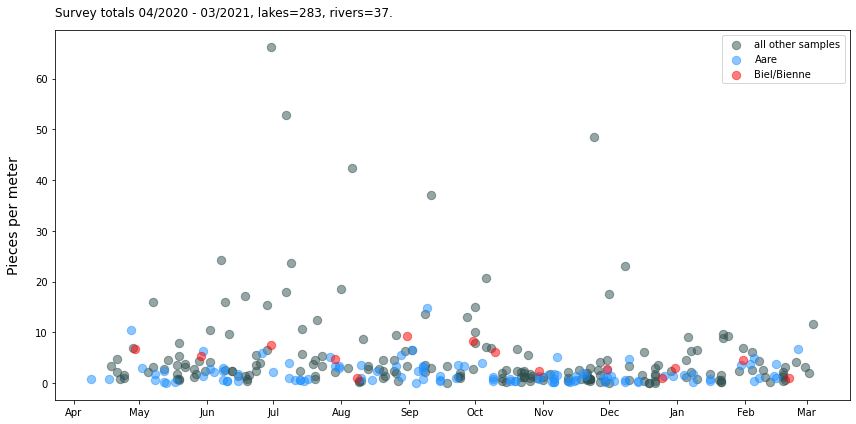

In [9]:
# adjust table kwargs
# tablecenter_k = dict(loc="center", bbox=(0,0,1,1), cellLoc='center')


if is_french:
    labels = ["tous les autres prélèvements", bassin_label, coi]
    title = F"{french_srs} {startyearmonth} - {endyearmonth}, lacs={lakecount}, rivières={rivercount}."
    y_label = F"{french_pcm}"
else:
    labels = ["all other samples", bassin_label, coi]
    title = F"Survey totals {startyearmonth} - {endyearmonth}, lakes={lakecount}, rivers={rivercount}."
    y_label = "Pieces per meter"
label_colors = ['darkslategray', 'dodgerblue', 'red']

# plot the results at different regional levels:
data = [a.daily_totals_all[~a.daily_totals_all.location.isin(b.bassin_beaches)], b.bassin_pcsm_day[~b.bassin_pcsm_day.location.isin(b.muni_beaches)], b.muni_pcsm_day]

# set output
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag= F"{title}", figure_num=figure_num)



# plot
scatterRegionalResults(data, labels, colors=label_colors, title=title, y_label=y_label, output=save_output, o_kwargs=output_kwargs)

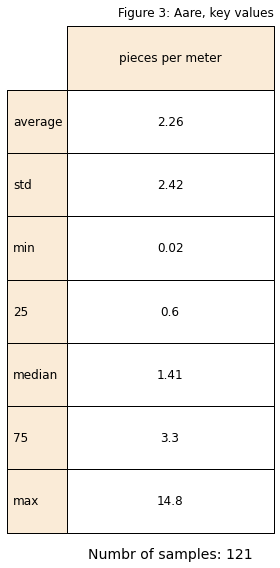

In [10]:
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="table", tag=F"key values {coi}", figure_num=figure_num)

a_sum_table, row_labels = makeTableOfKeyStatistics(b.bassin_pcsm_day)
nsamps = len(b.bassin_pcsm_day)    
    
make_one_column_table(a_sum_table, is_french, row_labels, nsamps, title=bassin_label, output=save_output, o_kwargs=output_kwargs, t_kwargs=tablecenter_k)

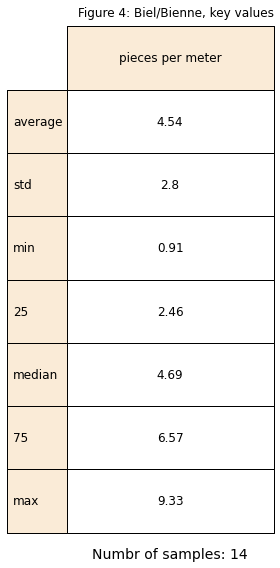

In [11]:
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="table", tag=F"key values {bassin_label}", figure_num=figure_num)

a_sum_table, row_labels = makeTableOfKeyStatistics(b.muni_pcsm_day)
nsamps = len(b.muni_pcsm_day)
make_one_column_table(a_sum_table, is_french, row_labels, nsamps, title=coi, output=save_output, o_kwargs=output_kwargs, t_kwargs=tablecenter_k)

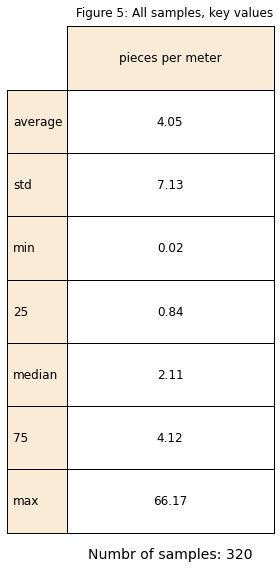

In [12]:
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="table", tag=F"key values all survyes", figure_num=figure_num)

a_sum_table, row_labels = makeTableOfKeyStatistics(a.daily_totals_all)
nsamps = len(a.daily_totals_all)
make_one_column_table(a_sum_table, is_french, row_labels, nsamps, title=samples_all, output=save_output,o_kwargs=output_kwargs, t_kwargs=tablecenter_k)

In [13]:
table_data = regionalCodeQty(b.bassin_code_totals, dfCodes, b.code_group_map)
top_ten, table_data_all = makeRegionalCodeQtyTable(table_data, b.bassin_code_pcsm_med)

In [14]:

# sum the % of total of the most common objects
ptotal = top_ten['% of total'].sum()
psum = top_ten.quantity.sum()
toptenqty = table_data_all.quantity.sum()

# context print tables
top_ten_table_p = top_ten.copy()
top_ten_table_p['% of total'] = top_ten_table_p['% of total'].astype('str')
top_ten_table_p['% of total'] = top_ten_table_p['% of total'] + "%"

# context is_french 
if is_french:
    bassin_tabledatacopy = top_ten_table_p.copy()
    bassin_tabledatacopy.reset_index(inplace=True)
    bassin_tabledatacopy['description'] = bassin_tabledatacopy.code.map(lambda x: count_k(fr_defs_codes[x], limit))
    bassin_tabledatacopy['group'] = bassin_tabledatacopy.group.map(lambda x: count_k(french_names[x], limit))
    bassin_tabledatacopy.rename(columns=french_columns, inplace=True)
    thetabledata = bassin_tabledatacopy[['code','description', 'matériel', 'quantité', '% du total','groupe']].copy()
    title = F"top {len(thetabledata)} codes {bassin_label}, {np.round(ptotal, 2)}% de {'{:,}'.format(toptenqty)} objets"
else:
    the_top_ten_table = top_ten_table_p[['code','description', 'material', 'quantity', '% of total','group']].copy()
    the_top_ten_table.reset_index=(True)
    thetabledata = the_top_ten_table.copy()
    title = F"top {len(thetabledata)} codes {bassin_label}, {np.round(ptotal, 2)}% of {'{:,}'.format(toptenqty)} objects"
 

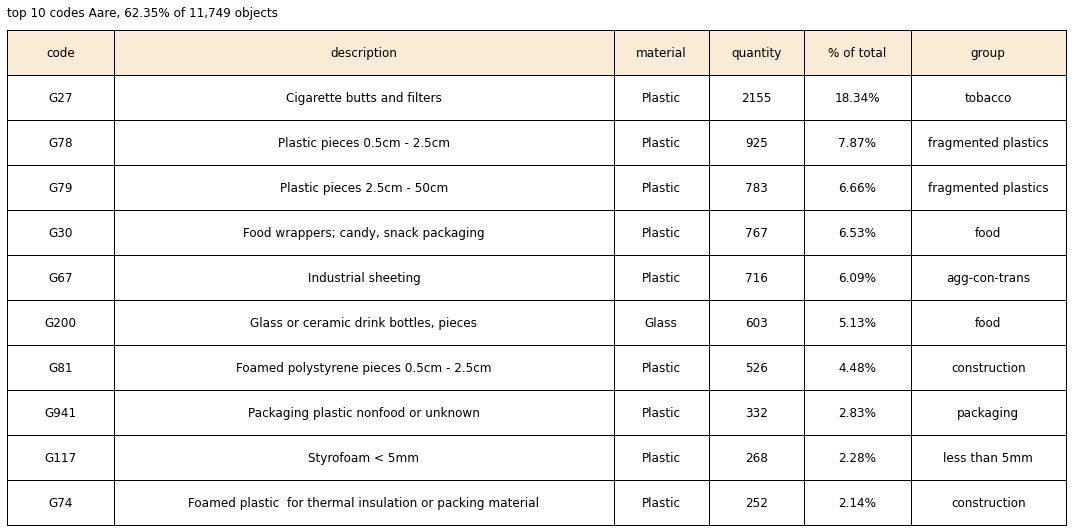

In [15]:
# plot the table
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="table", tag=F"top ten {bassin_label}", figure_num=figure_num)

# adjust the table kwargs (# of columns):
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[9, 42, 8, 8, 9,13], cellLoc='center')


makeMultiColumnTable(thetabledata, title=title, output=save_output, o_kwargs=output_kwargs, t_kwargs=tablecenter_k, tick_params=tabtickp_k, title_kwargs=title_k)

In [16]:
# compare the top-ten from the catchment area to the local and national results
# map the results from the different classes:
top_ten[coi] = top_ten.code.map(lambda x: b.muni_code_pcsm_med[x])
top_ten['all catchment areas'] = top_ten.code.map(lambda x: a.code_pcsm_med[x])

# change the pcs_m column to the name of the catchment area:
top_ten[bassin_label] = top_ten.pcs_m

# make the description the index
table_data = top_ten.set_index('description', drop=True) 
table_data = table_data[[coi, bassin_label, 'all catchment areas']]

if is_french:
    title=F"{bassin_label} les top-ten objets pièces par mètre"
else:
    title=F"{bassin_label} the top-ten objects, pieces per meter"

# toggle output

figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag=F"top ten {bassin_label} comparisson", figure_num=figure_num)

o_kwargs = output_kwargs

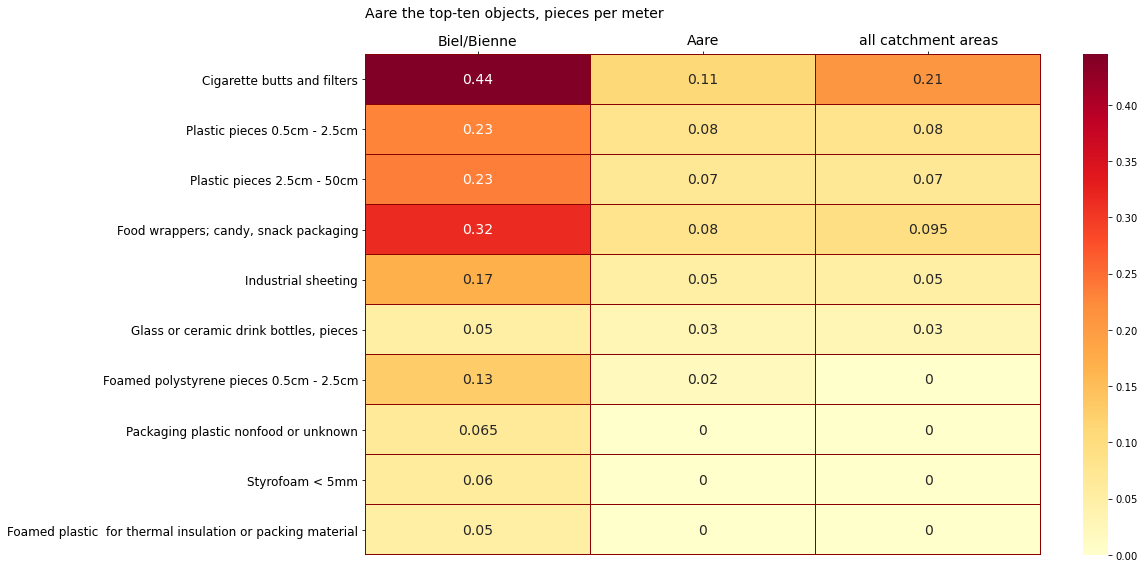

In [17]:
fig, ax = plt.subplots(figsize=(17,8))


sns.heatmap(data=table_data, cmap='YlOrRd', linewidth=0.1, linecolor='darkred', annot=True, ax=ax, annot_kws={"fontsize":14})
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=14)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=12, rotation=0)
ax.set_title(title, **title_k14)

plt.tight_layout()

if save_output:
        add_output(**o_kwargs)

plt.show()

plt.close()

In [18]:
# find the objects from the coi that exceed the median for catchment area:
exceeds_catchment_median = [x for x in b.muni_code_pcsm_med.index if b.muni_code_pcsm_med[x] > b.bassin_code_pcsm_med[x]]

# remove the objects that were already listed in the top ten
exceeds_catchment_median = [x for x in exceeds_catchment_median if x not in top_ten.code.values]

In [19]:
# apply that to the bassin table data:
codes_of_interest = table_data_all.loc[table_data_all.index.isin(exceeds_catchment_median)].copy()

# make a column for the coi results, map those
codes_of_interest[coi] = codes_of_interest.index.map(lambda x: b.muni_code_pcsm_med[x])

In [20]:
# make a column for the bassin results, map that
codes_of_interest[bassin_label] = codes_of_interest.index.map(lambda x: b.bassin_code_pcsm_med[x])

# sort for charting
codes_of_interest = codes_of_interest[[coi, bassin_label, 'description']].copy()
codes_of_interest.sort_values(by=coi, ascending=False, inplace=True)
codes_of_interest.set_index('description', inplace=True)


figure_num += 1

if is_french:
    title=F"Figure {figure_num}: {coi} objets d'intérêt, supérieure à la médiane de {bassin_label}"
else:
    title=F"Figure {figure_num}: {coi} objects of interest, greater than the median of {bassin_label}"



output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag=F"objects of interest {coi}", figure_num=figure_num)

o_kwargs = output_kwargs

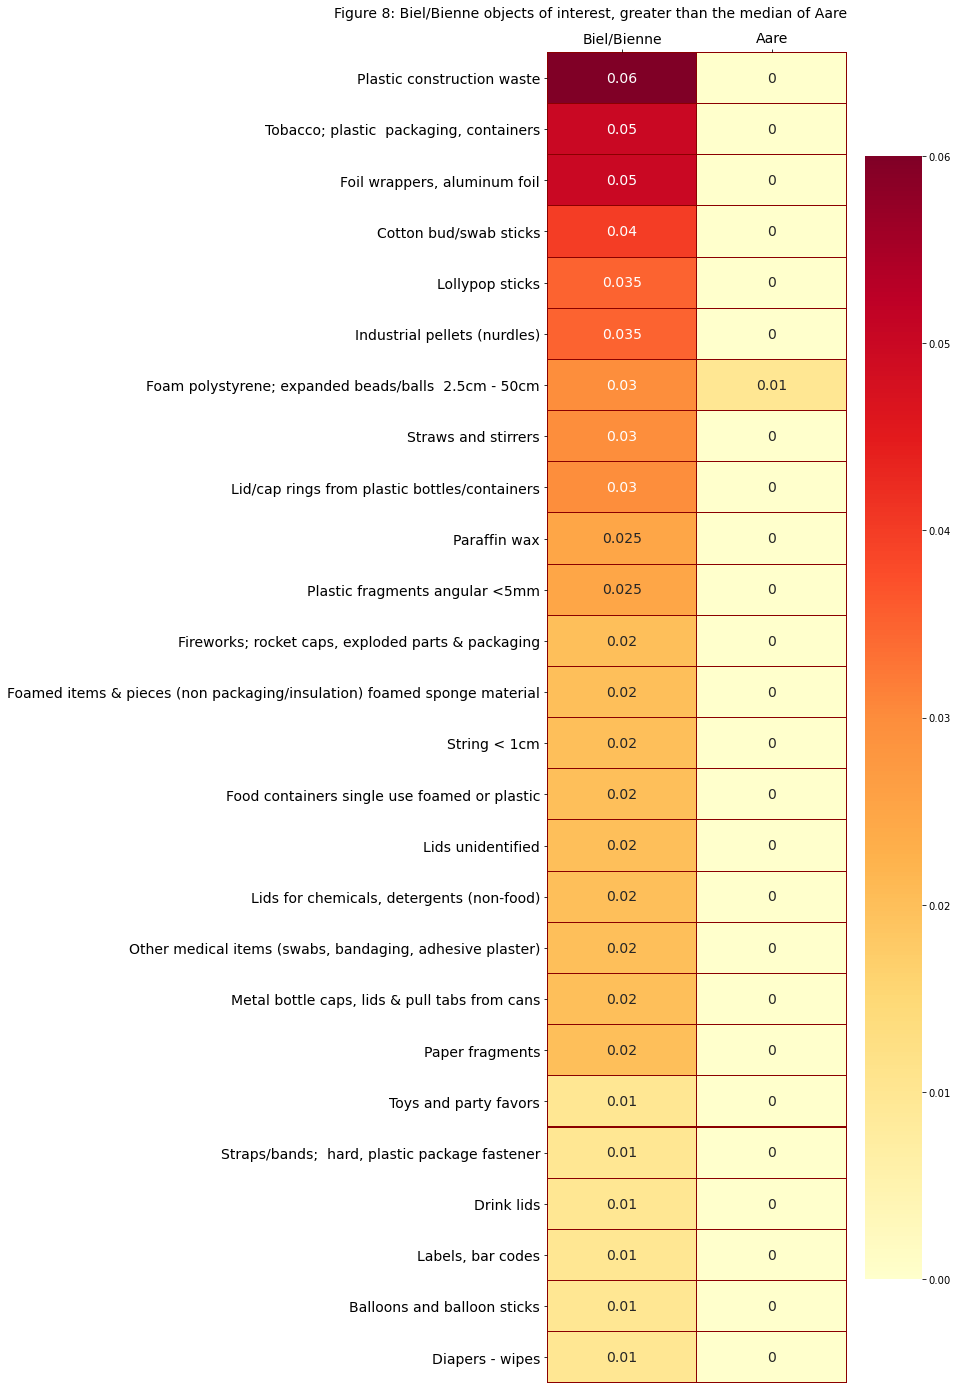

In [21]:

codes_of_interest.columns = [coi, bassin_label]

fig, ax = plt.subplots(figsize=(13,len(codes_of_interest)*.75))

sns.heatmap(data=codes_of_interest, cmap='YlOrRd', linewidth=0.1, linecolor='darkred', annot=True, ax=ax, annot_kws={"fontsize":14})
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=14)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=14, rotation=0)
ax.set_title(title, ha='right', loc='right', fontsize=14, pad=14)

plt.tight_layout()


if save_output:
    add_output(**o_kwargs)

plt.show()

plt.close()

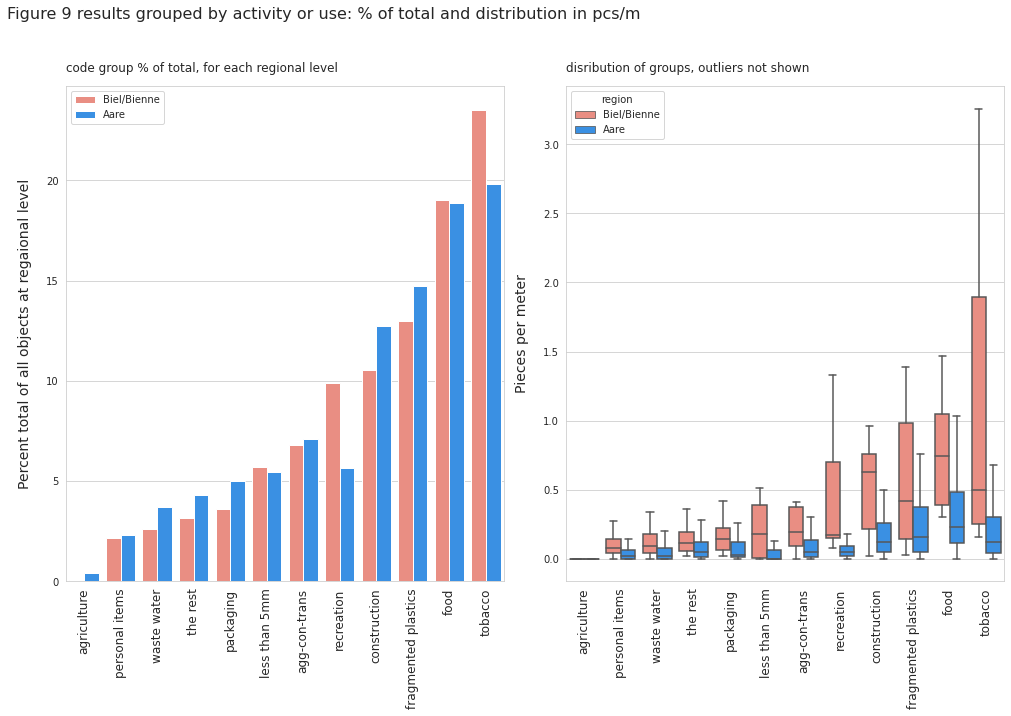

In [22]:
sns.set_style('whitegrid')

d=b.bassin_data.groupby(['groupname'], as_index=False).quantity.sum()
d['p_total'] = (d.quantity/d.quantity.sum())*100
d['p_total'] = d.p_total.round(2)
d['region'] = bassin_label

c=b.muni_data.groupby(['region','groupname'], as_index=False).quantity.sum()
c['p_total'] = (c.quantity/c.quantity.sum())*100
c['p_total']=c.p_total.round(2)
an_order_group = c.sort_values(by='p_total').groupname

e = c.append(d)

f = b.bassin_data.groupby(['region','water_name','location','loc_date', 'date', 'groupname'], as_index=False).pcs_m.sum()

# merge the data sets
these_groups = e

if is_french:
    these_groups['groupname'] = these_groups['groupname'].map(lambda x: french_names[x])
    f['groupname'] = f['groupname'].map(lambda x: french_names[x])
    title_bar_plot = F"groupe de codes % du total, pour chaque niveau régional"
    title_box_plot = F"distribution {french_bg}, {french_nooutliers}"
    y_label_bar = F"{french_pct} niveau régional"
    y_label_box = F"{french_pcm}"
else:
    title_bar_plot = F"code group % of total, for each regional level"
    title_box_plot = F"disribution of groups, outliers not shown"
    y_label_bar = "Percent total of all objects at regaional level"
    y_label_box = "Pieces per meter"



figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag='code groups: percentage of total, distribution, regional results', figure_num=figure_num)
o_kwargs = output_kwargs
    

colors = ['dodgerblue', 'salmon', 'teal', 'red','maroon','goldenrod', 'mediumspringgreen', 'slategray','olive','yellowgreen', 'purple', 'orange', 'cyan']
grouppalette = {x:colors[i] for i,x in enumerate(b.bassin_data.groupname.unique())}

a_form = mtick.FormatStrFormatter('%.0f%%')

fig, ax = plt.subplots(1,2, figsize=(14, 10))
an_order = [coi, bassin_label]


sns.barplot(data=e, x='groupname', hue='region', order=an_order_group, hue_order=an_order, palette={coi:'salmon', bassin_label:'dodgerblue'}, y='p_total', ax=ax[0])
ax[0].set_ylabel(y_label_bar, **ylab_k)
ax[0].set_title(title_bar_plot, **title_k)
ax[0].set_xlabel("")
ax[0].tick_params(axis='x', which='both',labelsize=12, rotation=90)
ax[0].legend(loc='upper left')    

sns.boxplot(data=f[['groupname','pcs_m', 'region']], x='groupname', order=an_order_group, y='pcs_m', hue='region', hue_order=an_order, palette={coi:'salmon', bassin_label:'dodgerblue'}, dodge=True, ax=ax[1], showfliers=False)
ax[1].set_ylabel(y_label_box, **ylab_k)
ax[1].set_title(title_box_plot, **title_k)
ax[1].set_xlabel("")
ax[1].tick_params(axis='x', which='both',labelsize=12, rotation=90)

if is_french:
    suptitle =F"Figure {figure_num} résultats regroupés par activité ou utilisation : % du total et répartition en pcs/m"
else:
    suptitle = F"Figure {figure_num} results grouped by activity or use: % of total and distribution in pcs/m"

plt.suptitle(suptitle, x=0, y=.99, ha='left', fontsize=16, linespacing=2)

    
plt.tight_layout()
plt.subplots_adjust(top=.88)

if save_output:
    add_output(**o_kwargs)
    

plt.show()
plt.close()

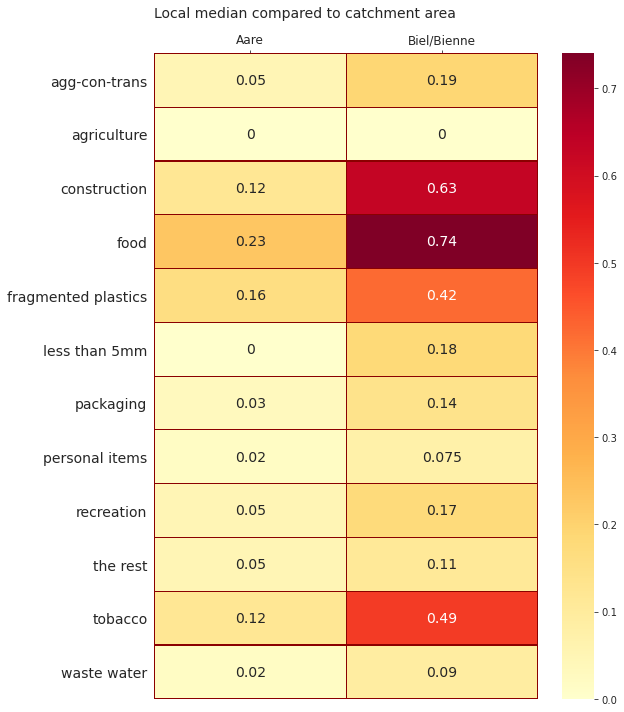

In [23]:
data =f.groupby(['region', 'groupname'], as_index=False).pcs_m.median()
data=data.pivot(columns='region', index='groupname')
data.columns = data.columns.get_level_values(1)

if is_french:
    title = F"groupes de codes: pièces médianes par mètre"
    
else:
    title = "Local median compared to catchment area"


figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag=F"code groups: {coi} and {bassin_label} median pcs/m", figure_num=figure_num)
o_kwargs = output_kwargs

fig, ax = plt.subplots(figsize=(9,10))

    
sns.heatmap(data=data, cmap='YlOrRd', linewidth=0.1, linecolor='darkred', annot=True, annot_kws={"fontsize":14}, ax=ax)
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=12)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=14, rotation=0)
ax.set_title(title, **title_k14)
plt.tight_layout()

if save_output:
    add_output(**o_kwargs)
plt.show()
plt.close()

In [24]:
table_data = regionalCodeQty(b.bassin_code_totals, dfCodes, b.code_group_map)
top_ten, table_data_all = makeRegionalCodeQtyTable(table_data, b.bassin_code_pcsm_med)

5


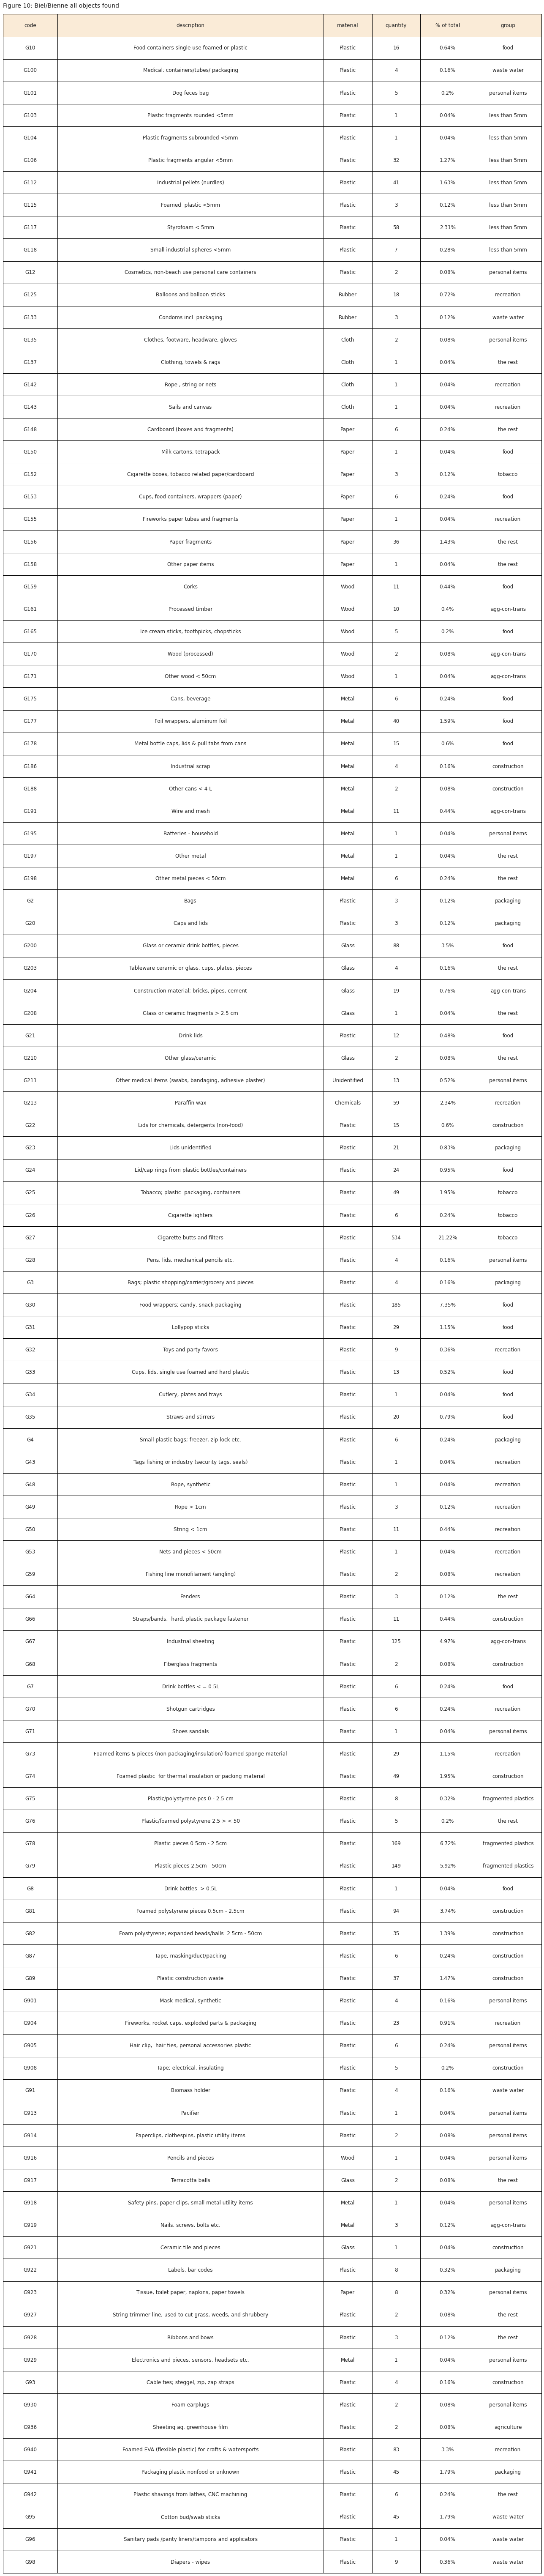

In [25]:
muni_tabledata = regionalCodeQty(b.muni_code_totals, dfCodes, b.code_group_map)

# context print tables
this_tabledata = muni_tabledata[muni_tabledata.quantity > 0].copy()
this_tabledata.reset_index(inplace=True)
a_total = muni_tabledata.quantity.sum()
this_tabledata['% of total'] = this_tabledata['% of total'].astype('str')
this_tabledata['% of total'] = this_tabledata['% of total'] + "%"
# context is_french 
if is_french:
    tabledatacopy = this_tabledata.copy()
    tabledatacopy.reset_index(inplace=True)
    tabledatacopy.sort_values(by='group', inplace=True)
    tabledatacopy['description'] = tabledatacopy.code.map(lambda x: count_k(fr_defs_codes[x], limit))
    tabledatacopy['group'] = tabledatacopy.group.map(lambda x: count_k(french_names[x], limit))
    tabledatacopy.rename(columns=french_columns, inplace=True)
    thetabledata = tabledatacopy[['code','description', 'matériel', 'quantité', '% du total','groupe']].copy()
    this_tabledata = thetabledata
    title = F"Figure {figure_num}: {coi} tous {a_total} objets trouvés"
else:
    this_tabledata = this_tabledata[['code','description', 'material', 'quantity', '% of total', 'group']]
    title = F"Figure {figure_num}: {coi} all objects found"
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[9, 44, 8, 8, 9,11], cellLoc='center')
figure_num += 1

output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="table", tag=F"all objects found {coi}", figure_num=figure_num)
o_kwargs = output_kwargs
# plot the table:
print(len(muni_tabledata.columns))
fig, ax = plt.subplots(figsize=(18, len(this_tabledata)*.75))

ax = make_table_grids(ax)
a_table = mpl.table.table(
    cellText=this_tabledata.values,
    colLabels=this_tabledata.columns,
    colColours=['antiquewhite' for col in list(this_tabledata.columns)],    
    ax=ax,
    **tablecenter_k)

# set parameters
table_fonts(a_table, size=12)
ax.tick_params(**tabtickp_k)

# add the table
ax.add_table(a_table)

ax.set_title(title, **title_k14)

plt.tight_layout()

if save_output:
    add_output(**o_kwargs)

plt.show()
plt.close()

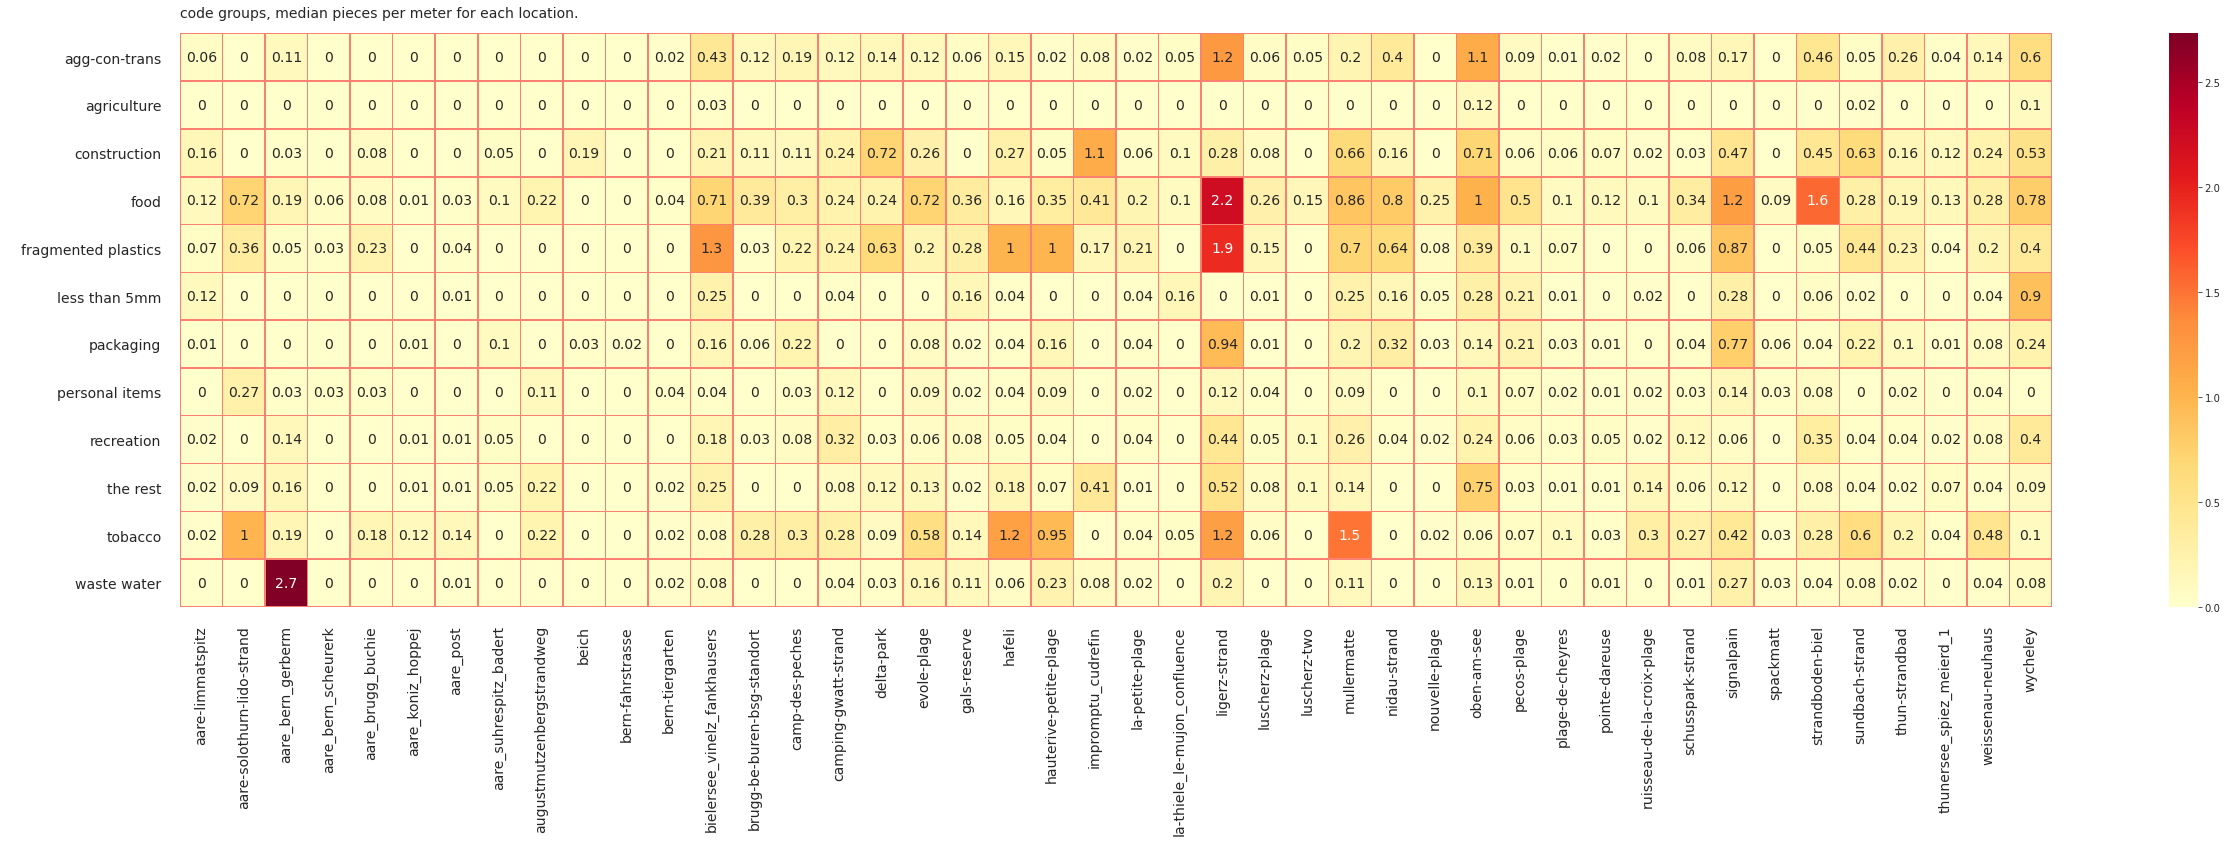

In [26]:
heat_map_palette = 'YlOrRd'
linecolor = 'salmon'

this_data = b.bassin_data.groupby(['location','loc_date', 'groupname'], as_index=False).pcs_m.sum()
a=this_data.groupby(['location','groupname'], as_index=False).pcs_m.median()
a['pcs_m'] = a.pcs_m.round(2)
figure_num += 1
if is_french:
    a['groupname'] = a.groupname.map(lambda x: french_names[x])
    title = F"Figure {figure_num}: {bassin_label} groupes de codes, pièces par mètre médiane pour chaque lieu."
else:
    title = "code groups, median pieces per meter for each location."
# figure_num += 1
# atype="figure"
# figname = F"figure{figure_num}.jpg"
# tag = F"{bassin_label} all locations median pcs/m"
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag=F"{bassin_label} all locations median pcs/m", figure_num=figure_num)
o_kwargs = output_kwargs

fig,axx = plt.subplots(figsize=(len(a.location.unique())*.8,12))

a=a.pivot(columns='location', index='groupname')
# other_locs = [x for x in a.columns.get_level_values(1) if x not in lavey_locs]
# a = a.reindex(this_order, axis=1, level=1)
sns.heatmap(a,
            cmap=heat_map_palette, ax=axx, annot=True, annot_kws={'fontsize':14}, linewidths=.5, linecolor=linecolor)
labels = [a_text.get_text() for a_text in axx.get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[6:]
    newlabels.append(newlabel)

axx.set_xticklabels(newlabels, fontsize=14)
axx.set_ylabel(" ")
axx.set_xlabel(" ")
axx.tick_params(axis='both', labelsize=14, pad=15)
axx.set_title(F"{title}", **title_k14)

    
plt.tight_layout()

if save_output:
    add_output(**o_kwargs)

plt.show()
plt.close()

### Figures and data produced by this notebook:



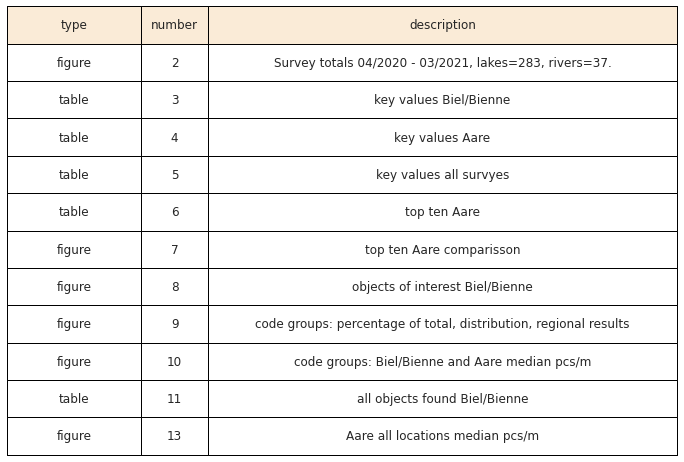

In [27]:
files_df = pd.DataFrame(files_generated)
files_df.rename(columns={'tag':'description'}, inplace=True)

files_df = files_df[['type','number', 'description']]
files_df = files_df.sort_values(by='type')
files_df.sort_values(by=['number', 'type'], inplace=True)
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', colWidths=[20,10,70], fontsize=12)
tablecenter_kx = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12)

figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="table", tag=F"Index of fiugres", figure_num=figure_num)
o_kwargs = output_kwargs
        
with sns.axes_style('white', {'xtick.color':'white', 'ytick.color':'white'}):
    fig, axs = plt.subplots(figsize=(12,(len(files_df)*.75)), frameon=False)
    figure_num += 1
    sns.despine(fig=fig, top=True, left=True, right=True, bottom=True)

    make_table_grids(axs)    

    a_table = axs.add_table(mpl.table.table(
        cellText=files_df.values,
        colLabels=files_df.columns,
        colColours=['antiquewhite' for col in files_df.columns],
        ax=axs,
        **tablecenter_k))


    table_fonts(a_table)

    axs.tick_params(**tabtickp_k)
    
    if save_output:
        add_output(**o_kwargs)

    plt.show()
    plt.close()

In [28]:
# boxes = useThis.groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()
# boxes_l = useThis[useThis.location.isin(lavey_locs)].groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()
# boxes_b = useThis[useThis.location.isin(bassin_locs)].groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()

# get_an_order_l = boxes_l.groupby('groupname').pcs_m.median()
# an_order_of_boxes_l = get_an_order_l.sort_values(ascending=True)
# a_box_order_l = an_order_of_boxes_l.index


In [29]:
# sig_vals =f.groupby('groupname').pcs_m.quantile(sig)

In [30]:
# boxes = f.groupby(['loc_date', 'date','location','water_name', 'groupname'], as_index=False).pcs_m.sum()

In [31]:
# get the significant value for each code group

# sig_vals_b = boxes_b.groupby('groupname').pcs_m.quantile(sig)
# get the significant value for each code
# sig_vals_code = useThis.groupby('code').pcs_m.median()
# sig_vals_bassin  = useThis[useThis.location.isin(bassin_locs)].groupby('code').pcs_m.median()
# bassin_pcsm = newdfx[(newdfx.location.isin(bassin_locs))].groupby('code').pcs_m.median()


# map the significant value to the results
# boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# create a boolean for significant
# boxes['significant'] = boxes.pcs_m >= boxes.limit

# map to number of samples, and significant values
# survey_totals = a.daily_totals_all
# survey_totals.reset_index(inplace=True)

# number of samples per lake
# tries = survey_totals.groupby(['water_name']).loc_date.nunique()

# number of locations per lake
# num_locations = survey_totals.groupby('water_name').location.nunique()

# fails: number of locations where object group has been identified
# num_with =survey_totals[survey_totals.quantity > 0].groupby(['water_name', 'groupname']).location.nunique()

# fails: number of samples with the object group
# samps_with = survey_totals[survey_totals.quantity > 0].groupby(['water_name', 'groupname']).loc_date.nunique()

# median pcs_m
# median_pcs = boxes.groupby(['water_name', 'groupname']).pcs_m.median()

# mean pcs_m
# mean_pcs = boxes.groupby(['water_name', 'groupname']).pcs_m.mean()

# significant values
# determine wether or not the event was greater than the 90th percentile

# map limit to data
# boxes['limit'] = boxes.groupname.map(lambda x: sig_vals[x])

# create boolean
# boxes['significant'] = boxes.pcs_m >= boxes.limit

# make a df of tests and test failures
# fails = boxes.groupby(['water_name', 'groupname'], as_index=False).significant.sum()

# get the number of samples for the lake
# fails['samples'] = fails.water_name.map(lambda x: tries[x])

# # display the ratio of significant values to samples
# fails['frequency_s'] = fails.significant.astype('str') + '/' + fails.samples.astype('str')

# # the number of locations
# fails['locations'] = fails.water_name.map(lambda x: num_locations[x])

# def locations_with(x,y,somdata):
#     try:
#         has = somdata[x][y]        
#     except:
#         has = 0
#     return has
        
# # the number of locations where the object group has been identified
# fails['loc_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], num_with), axis=1)

# # the number of samples where the object group has been identified
# fails['samp_with'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], samps_with), axis=1)

# # samples frequency of failure
# fails['frequency'] = fails.samp_with.astype('str') + '/' + fails.samples.astype('str')

# # locations frequency of failure
# fails['frequency_l'] = fails.loc_with.astype('str') + '/' + fails.locations.astype('str')

# # median/mean pcs_m:
# fails['median pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], median_pcs), axis=1)
# fails['mean pcs/m'] = fails.apply(lambda x:locations_with(x['water_name'], x['groupname'], mean_pcs), axis=1)

# # likelihood
# fails['likelihood'] = ((fails.loc_with/fails.locations)*(fails.samp_with/(fails.samples+1)))

# def make_minimum_likelihood(x,samples=100):
#     # even if an item has never been found
#     # it is assumed that there is always a chance
#     # that it may be found. That chance is equal
#     # 1/n samples * 1/n location (found at one sample and one location)
#     if x == 0 :
#             min_val = (1/samples)
#     else:
#         min_val = x
#     return min_val


# fails['likelihood'] = fails.apply(lambda x:make_minimum_likelihood(x['likelihood']), axis=1)

# table_data = fails[['water_name','frequency_l', 'frequency',  'frequency_s', 'likelihood','median pcs/m', 'groupname']].copy()
# table_data.rename(columns={'water_name':'name', 'frequency_l':"# locations", 'frequency':"# samples", 'frequency_s':'# significant'}, inplace=True)

# national_median = boxes.groupby('groupname').pcs_m.median()

# this_data = pd.DataFrame(boxes_l.groupby('groupname').pcs_m.median())
# this_data['catchment area'] = this_data.index.map(lambda x:lavey_group_pcsm[x] )
# if is_french:
#     this_data.rename(columns={'catchment area':'bassin versant', 'pcs_m':'résultats locaux'}, inplace=True)
#     this_data['groupname'] = this_data.index.map(french_names)
#     this_data.set_index('groupname', inplace=True)

In [32]:
# # map number of sample per locations
# tries_l = boxes.groupby('location').loc_date.nunique()

# # map number of times at least one item was found
# fails_l = boxes[boxes.pcs_m > 0].groupby(['location', 'groupname']).loc_date.nunique()

In [33]:
# # make a df to track codegroup fail rates for each location
# fails_beach = boxes.groupby(['location', 'water_name','groupname'], as_index=False).pcs_m.median()

# # add a tries and fails column for each location and group
# fails_beach['tries'] = fails_beach.location.map(lambda x: tries_l[x])
# fails_beach['fails'] = fails_beach.apply(lambda x:locations_with(x['location'], x['groupname'], fails_l), axis=1)

# # the ratio samples to failures
# fails_beach['likelihood'] = (fails_beach.fails/fails_beach.tries)

In [34]:
# get the fail rate per beach (how many times the quantity was greater than zero)
# fails_beach_bassin  = fails_beach[fails_beach.water_name.isin(bassin)].groupby('groupname').agg({ 'tries':'sum', 'fails':'sum'})
# fails_beach_bassin['group_rates'] = fails_beach_bassin.fails/ fails_beach_bassin.tries
# fails_beach_lavey = fails_beach[fails_beach.location.isin(lavey_locs)]

In [35]:
# a = boxes.groupby('location').significant.sum()
# these_beaches['significant'] = these_beaches.index.map(lambda x: a.loc[x])
# these_beaches['median pcs/m'] = these_beaches.index.map(lambda x: allsurveys_pcs_median[x])
# these_beaches.to_csv(F"{project_directory}/these_beaches.csv")

In [36]:
# # this_data = fails_beach[fails_beach.water_name.isin(bassin)].copy()
# this_data['pop'] = b.bassin_data.location.map(lambda x: these_beaches.loc[x]['population'])
# this_data = this_data.sort_values(by='pop')
# this_order = this_data.location.unique()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch